<h1>Group 37 Project Report: An Empirical Analysis of Pulsar Signalling <h1>

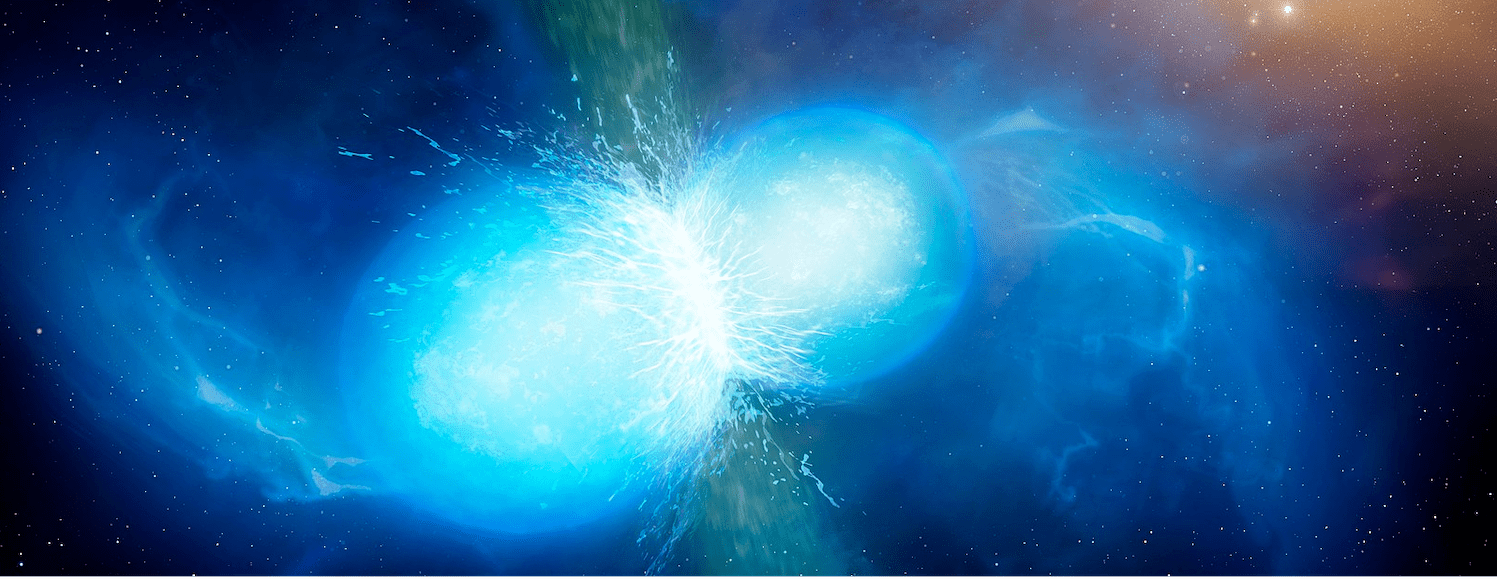

<font size="2"> <i>image attribution</i>: University of Warwick/Mark Garlick, CC BY 4.0 <https://creativecommons.org/licenses/by/4.0>, via Wikimedia Commons </font>

*Total Word Count: 621*

Write the Introduction Here

In [14]:
#Done to remove warning messages from the proposal and improve readability
options(warn=-1) 
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6, repr.matrix.max.cols = 4)
set.seed(3333)

In [15]:
HTRU2_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"

download.file(HTRU2_url, destfile = "HTRU_2.zip") 

#Unz used here as the downloaded file in question is not a raw csv file - but a .zip file with a csv file inside
HTRU_df <- unz("HTRU_2.zip", "HTRU_2.csv") %>% 
    read_csv(col_names = c("Mean of the integrated profile",
                           "Standard deviation of the integrated profile",
                           "Excess kurtosis of the integrated profile",
                           "Skewness of the integrated profile",
                           "Mean of the DM-SNR curve",
                           "Standard deviation of the DM-SNR curve",
                           "Excess kurtosis of the DM-SNR curve",
                           "Skewness of the DM-SNR curve",
                           "Class"))
HTRU_df

Parsed with column specification:
cols(
  `Mean of the integrated profile` = col_double(),
  `Standard deviation of the integrated profile` = col_double(),
  `Excess kurtosis of the integrated profile` = col_double(),
  `Skewness of the integrated profile` = col_double(),
  `Mean of the DM-SNR curve` = col_double(),
  `Standard deviation of the DM-SNR curve` = col_double(),
  `Excess kurtosis of the DM-SNR curve` = col_double(),
  `Skewness of the DM-SNR curve` = col_double(),
  Class = col_double()
)



Mean of the integrated profile,Standard deviation of the integrated profile,⋯,Skewness of the DM-SNR curve,Class
<dbl>,<dbl>,⋯,<dbl>,<dbl>
140.5625,55.68378,⋯,74.24222,0
102.5078,58.88243,⋯,127.39358,0
103.0156,39.34165,⋯,63.17191,0
⋮,⋮,⋱,⋮,⋮
119.3359,59.93594,⋯,4.595173,0
114.5078,53.90240,⋯,134.238910,0
57.0625,85.79734,⋯,1.429475,0


In [16]:
colnames(HTRU_df) <- make.names(colnames(HTRU_df))

#the ifelse() function is used here to read the 0 or 1 class values, then exchange with "Pulsar Star" or "Interference" characters respectively
pulsar_df <- HTRU_df %>%
    mutate(Class = as.factor(ifelse(Class == 1, "Pulsar Star", "Interference")))

In [17]:
pulsar_split <- initial_split(pulsar_df, prop = 0.75, strata = Class) 
pulsar_training <- training(pulsar_split)
pulsar_testing <- testing(pulsar_split)

In [18]:
pulsar_training

Mean.of.the.integrated.profile,Standard.deviation.of.the.integrated.profile,⋯,Skewness.of.the.DM.SNR.curve,Class
<dbl>,<dbl>,⋯,<dbl>,<fct>
103.01562,39.34165,⋯,63.17191,Interference
136.75000,57.17845,⋯,53.59366,Interference
88.72656,40.67223,⋯,252.56731,Interference
⋮,⋮,⋱,⋮,⋮
122.5547,49.48561,⋯,8.297092,Interference
119.3359,59.93594,⋯,4.595173,Interference
114.5078,53.90240,⋯,134.238910,Interference


**Forward Selection**

In [19]:
p_cols <- colnames(pulsar_training %>% select(-Class))
p_cols

[1] "Mean.of.the.integrated.profile"              
[2] "Standard.deviation.of.the.integrated.profile"
[3] "Excess.kurtosis.of.the.integrated.profile"   
[4] "Skewness.of.the.integrated.profile"          
[5] "Mean.of.the.DM.SNR.curve"                    
[6] "Standard.deviation.of.the.DM.SNR.curve"      
[7] "Excess.kurtosis.of.the.DM.SNR.curve"         
[8] "Skewness.of.the.DM.SNR.curve"

In [20]:
general_formula <- paste("Class ~", paste(p_cols, collapse = "+"))
general_formula

[1] "Class ~ Mean.of.the.integrated.profile+Standard.deviation.of.the.integrated.profile+Excess.kurtosis.of.the.integrated.profile+Skewness.of.the.integrated.profile+Mean.of.the.DM.SNR.curve+Standard.deviation.of.the.DM.SNR.curve+Excess.kurtosis.of.the.DM.SNR.curve+Skewness.of.the.DM.SNR.curve"

In [22]:
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                set_engine("kknn") %>%
                set_mode("classification")

pulsar_vfold <- vfold_cv(pulsar_training, v = 5, strata = Class)

selected <- c()

for (i in 1:length(p_cols)) {
    
    accs <- list()
    models <- list()
    
    for (j in 1:length(p_cols)) {
        
        preds_new <- c(selected, p_cols[[j]])
        model_string <- paste("Class", "~", paste(preds_new, collapse="+"))
        
        pulsar_recipe <- recipe(as.formula(model_string), data = pulsar_training) %>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors())
        
        acc <- workflow() %>%
                        add_recipe(pulsar_recipe) %>%
                        add_model(knn_spec) %>%
                        tune_grid(resamples = pulsar_vfold, grid = 10) %>%
                        collect_metrics() %>%
                        filter(.metric == "accuracy") %>%
                        summarize(mx = max(mean))
        
        acc <- acc$mx %>% unlist()
        
        accs[[j]] <- acc
        
        models[[j]] <- model_string        
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>%
                    add_row(size = i, 
                            model_string = models[[jstar]], 
                            accuracy = accs[[jstar]])
    selected <- c(selected, p_cols[[jstar]])
    p_cols <- p_cols[-jstar]    
}

accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Class ~ Excess.kurtosis.of.the.integrated.profile,0.9772051
2,Class ~ Excess.kurtosis.of.the.integrated.profile+Mean.of.the.DM.SNR.curve,0.9797378
3,Class ~ Excess.kurtosis.of.the.integrated.profile+Mean.of.the.DM.SNR.curve+Mean.of.the.integrated.profile,0.9797380
⋮,⋮,⋮
6,Class ~ Excess.kurtosis.of.the.integrated.profile+Mean.of.the.DM.SNR.curve+Mean.of.the.integrated.profile+Standard.deviation.of.the.integrated.profile+Standard.deviation.of.the.DM.SNR.curve+Skewness.of.the.integrated.profile,0.9795145
7,Class ~ Excess.kurtosis.of.the.integrated.profile+Mean.of.the.DM.SNR.curve+Mean.of.the.integrated.profile+Standard.deviation.of.the.integrated.profile+Standard.deviation.of.the.DM.SNR.curve+Skewness.of.the.integrated.profile+Skewness.of.the.DM.SNR.curve,0.9792165
8,Class ~ Excess.kurtosis.of.the.integrated.profile+Mean.of.the.DM.SNR.curve+Mean.of.the.integrated.profile+Standard.deviation.of.the.integrated.profile+Standard.deviation.of.the.DM.SNR.curve+Skewness.of.the.integrated.profile+Skewness.of.the.DM.SNR.curve+Excess.kurtosis.of.the.DM.SNR.curve,0.9789186


### 